In [40]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from PIL import Image
import cv2
import os

## Read images

In [42]:
path = '../data/'
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
])
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_dataset = datasets.ImageFolder(path)


In [43]:
img_dataset

Dataset ImageFolder
    Number of datapoints: 24998
    Root location: ../data/

### Prepare dataset

In [44]:
### config
BATCH_SIZE = 512
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
NUM_CLASSES = 2
EPOCHS = 10


In [45]:
num_samples = len(img_dataset)
n_train = int(num_samples * TRAIN_RATIO)
n_val = int(num_samples * VAL_RATIO)
n_test = num_samples - n_train - n_val
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(img_dataset, [n_train, n_val, n_test])
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

In [46]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Model 

In [47]:
class TransfomerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, ff_dim, dropout=0.1):
        super(TransfomerEncoder, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim, bias=True)
        )
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    def forward(self, x):
        norm_1 = self.norm1(x)
        attn_output, _ = self.attn(norm_1, norm_1, norm_1)
        attn_output = self.dropout1(attn_output)
        x = x + attn_output # skip connection
        norm_2 = self.norm2(x)
        ffn_output = self.dropout2(self.ff(norm_2))
        ffn_output = ffn_output + x # skip connection
        return ffn_output

In [48]:
class PatchPositionEmbedding(nn.Module): # add CLS token
    def __init__(self, embed_dim, patch_size, img_size):
        super(PatchPositionEmbedding, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        scale = 1.0 / np.sqrt(embed_dim)
        self.cls_embedding = nn.Parameter(scale*torch.randn(1, embed_dim))
        self.position_embedding = nn.Parameter(scale*torch.randn((img_size // patch_size) ** 2 + 1, embed_dim))
    def forward(self, x):
        x = self.conv1(x) # shape: (batch_size, embed_dim, h, w)
        x = x.reshape(x.shape[0], x.shape[1], -1) # shape: (batch_size, embed_dim, num_patches)
        x = x.permute(0, 2, 1) # permute to (batch_size, num_patches, embed_dim)
        cls_embed = self.cls_embedding.to(x.dtype) + torch.zeros((x.shape[0], 1, x.shape[-1]), device=x.device) # shape: (batch_size, 1, embed_dim)
        x = torch.cat((cls_embed, x), dim=1) # shape: (batch_size, num_patches + 1, embed_dim)
        x = x + self.position_embedding.to(x.dtype) # shape: (batch_size, num_patches + 1, embed_dim)
        return x
        

In [49]:
class ViT(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, ff_dim, num_classes, patch_size, drop_out):
        super(ViT, self).__init__()
        self.patch_embedding = PatchPositionEmbedding(embed_dim, patch_size, img_size=224)
        self.transformer_encoder = TransfomerEncoder(embed_dim, num_heads, num_layers, ff_dim, drop_out)
        self.fc1 = nn.Linear(embed_dim, embed_dim)
        self.fc2 = nn.Linear(embed_dim, num_classes)
        self.dropout = nn.Dropout(drop_out)
    def forward(self, x):
        # take position embedding
        output = self.patch_embedding(x)
        output = self.transformer_encoder(output)
        output = output[:,0,:] # take the CLS token
        output = self.fc1(output)
        output = self.dropout(output)
        output = F.relu(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

        
        

In [51]:
samples = next(iter(train_loader))
img, label = samples[0], samples[1]
print(img.shape, label.shape)
model = ViT(embed_dim=512, num_heads=8, num_layers=4, ff_dim = 1024, num_classes=NUM_CLASSES, patch_size=16, drop_out=0.1)
from torchsummary import summary
summary(model, img.shape[1:], device='cpu')

torch.Size([512, 3, 224, 224]) torch.Size([512])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 512, 14, 14]         393,216
PatchPositionEmbedding-2             [-1, 197, 512]               0
         LayerNorm-3             [-1, 197, 512]           1,024
MultiheadAttention-4  [[-1, 197, 512], [-1, 2, 2]]               0
           Dropout-5             [-1, 197, 512]               0
         LayerNorm-6             [-1, 197, 512]           1,024
            Linear-7            [-1, 197, 1024]         525,312
              ReLU-8            [-1, 197, 1024]               0
            Linear-9             [-1, 197, 512]         524,800
          Dropout-10             [-1, 197, 512]               0
TransfomerEncoder-11             [-1, 197, 512]               0
           Linear-12                  [-1, 512]         262,656
          Dropout-13                  [-1, 512]

## Training

In [52]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    return running_loss / len(dataloader), correct / total
def evaluate(model, dataloader, optimizer, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return running_loss / len(dataloader), correct / total




In [53]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


c:\Users\PC\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1/10, Train Loss: 0.6966, Train Acc: 0.5015, Val Loss: 0.6971, Val Acc: 0.5130
Epoch 2/10, Train Loss: 0.6959, Train Acc: 0.4996, Val Loss: 0.6937, Val Acc: 0.4870
Epoch 3/10, Train Loss: 0.6941, Train Acc: 0.5069, Val Loss: 0.6935, Val Acc: 0.5130


OSError: broken data stream when reading image file

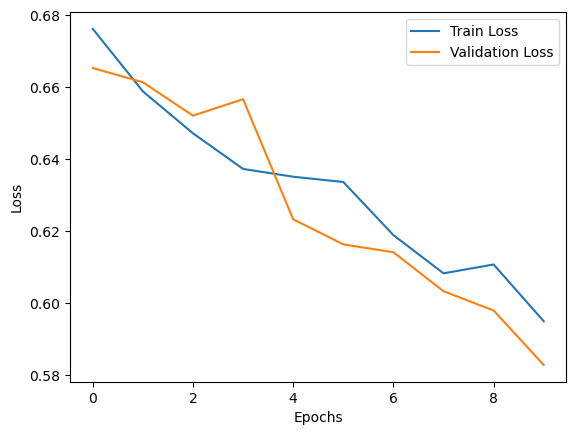

In [29]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [96]:
torch.cuda.empty_cache()

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
